 <h3 align="left"><center><font color='#DEB887'>
Model Selection Workflow Using Cross-Validation</font></center></h3> 

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<center><img src="https://media.giphy.com/media/yeUxljCJjH1rW/giphy.gif" width="800"></center><br></br>
<h3 align="left"><font color='#DEB887'>About The Data:</font></h3>
    
* Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.
* People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

<h3 align="left"><font color='#DEB887'>About Features:</font></h3>
    
🔘 **Age** : age of the patient [years]

🔘 **Sex** : sex of the patient [M: Male, F: Female]

🔘 **ChestPainType** : chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

🔘 **RestingBP** : resting blood pressure [mm Hg]

🔘 **Cholesterol** : serum cholesterol [mm/dl]

🔘 **FastingBS** : fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

🔘 **RestingECG** : resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and    ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

🔘 **MaxHR** : maximum heart rate achieved [Numeric value between 60 and 202]

🔘 **ExerciseAngina** : exercise-induced angina [Y: Yes, N: No]

🔘 **Oldpeak** : oldpeak = ST [Numeric value measured in depression]

🔘 **ST_Slope** : the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

🔘 **HeartDisease** : output class [1: heart disease, 0: Normal]


In [1]:
# !wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
# from IPython.core.display import HTML
# with open('./CSS.css', 'r') as file:
#     custom_css = file.read()

# HTML(custom_css)

>### Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
from termcolor import colored

import time
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import KFold, StratifiedKFold , cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,auc,accuracy_score, confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')


rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

>### Data Collection

In [3]:
df=pd.read_csv("heart.csv")
df.head(14).style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border': '1.5px  solid black'})

> ### Data Cleaning

In [4]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [5]:
summary(df).style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'}).background_gradient(cmap='YlOrBr')

data shape: (918, 12)


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
📌

* Fortunately, there are no missing data but there are many unique values in some columns
* In the <b> Cholesterol </b> column the max value is <font COLOR="red"> 603</font> so I think that there are outliers 


In [6]:
# the number of duplicate rows
df.duplicated().sum()

0

In [7]:
num_col = df.select_dtypes(include=np.number)
cat_col = df.select_dtypes(exclude=np.number)
num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("num_cols ",num_cols,"\n")
print("cat_cols ",cat_cols)

num_cols  ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease'] 

cat_cols  ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


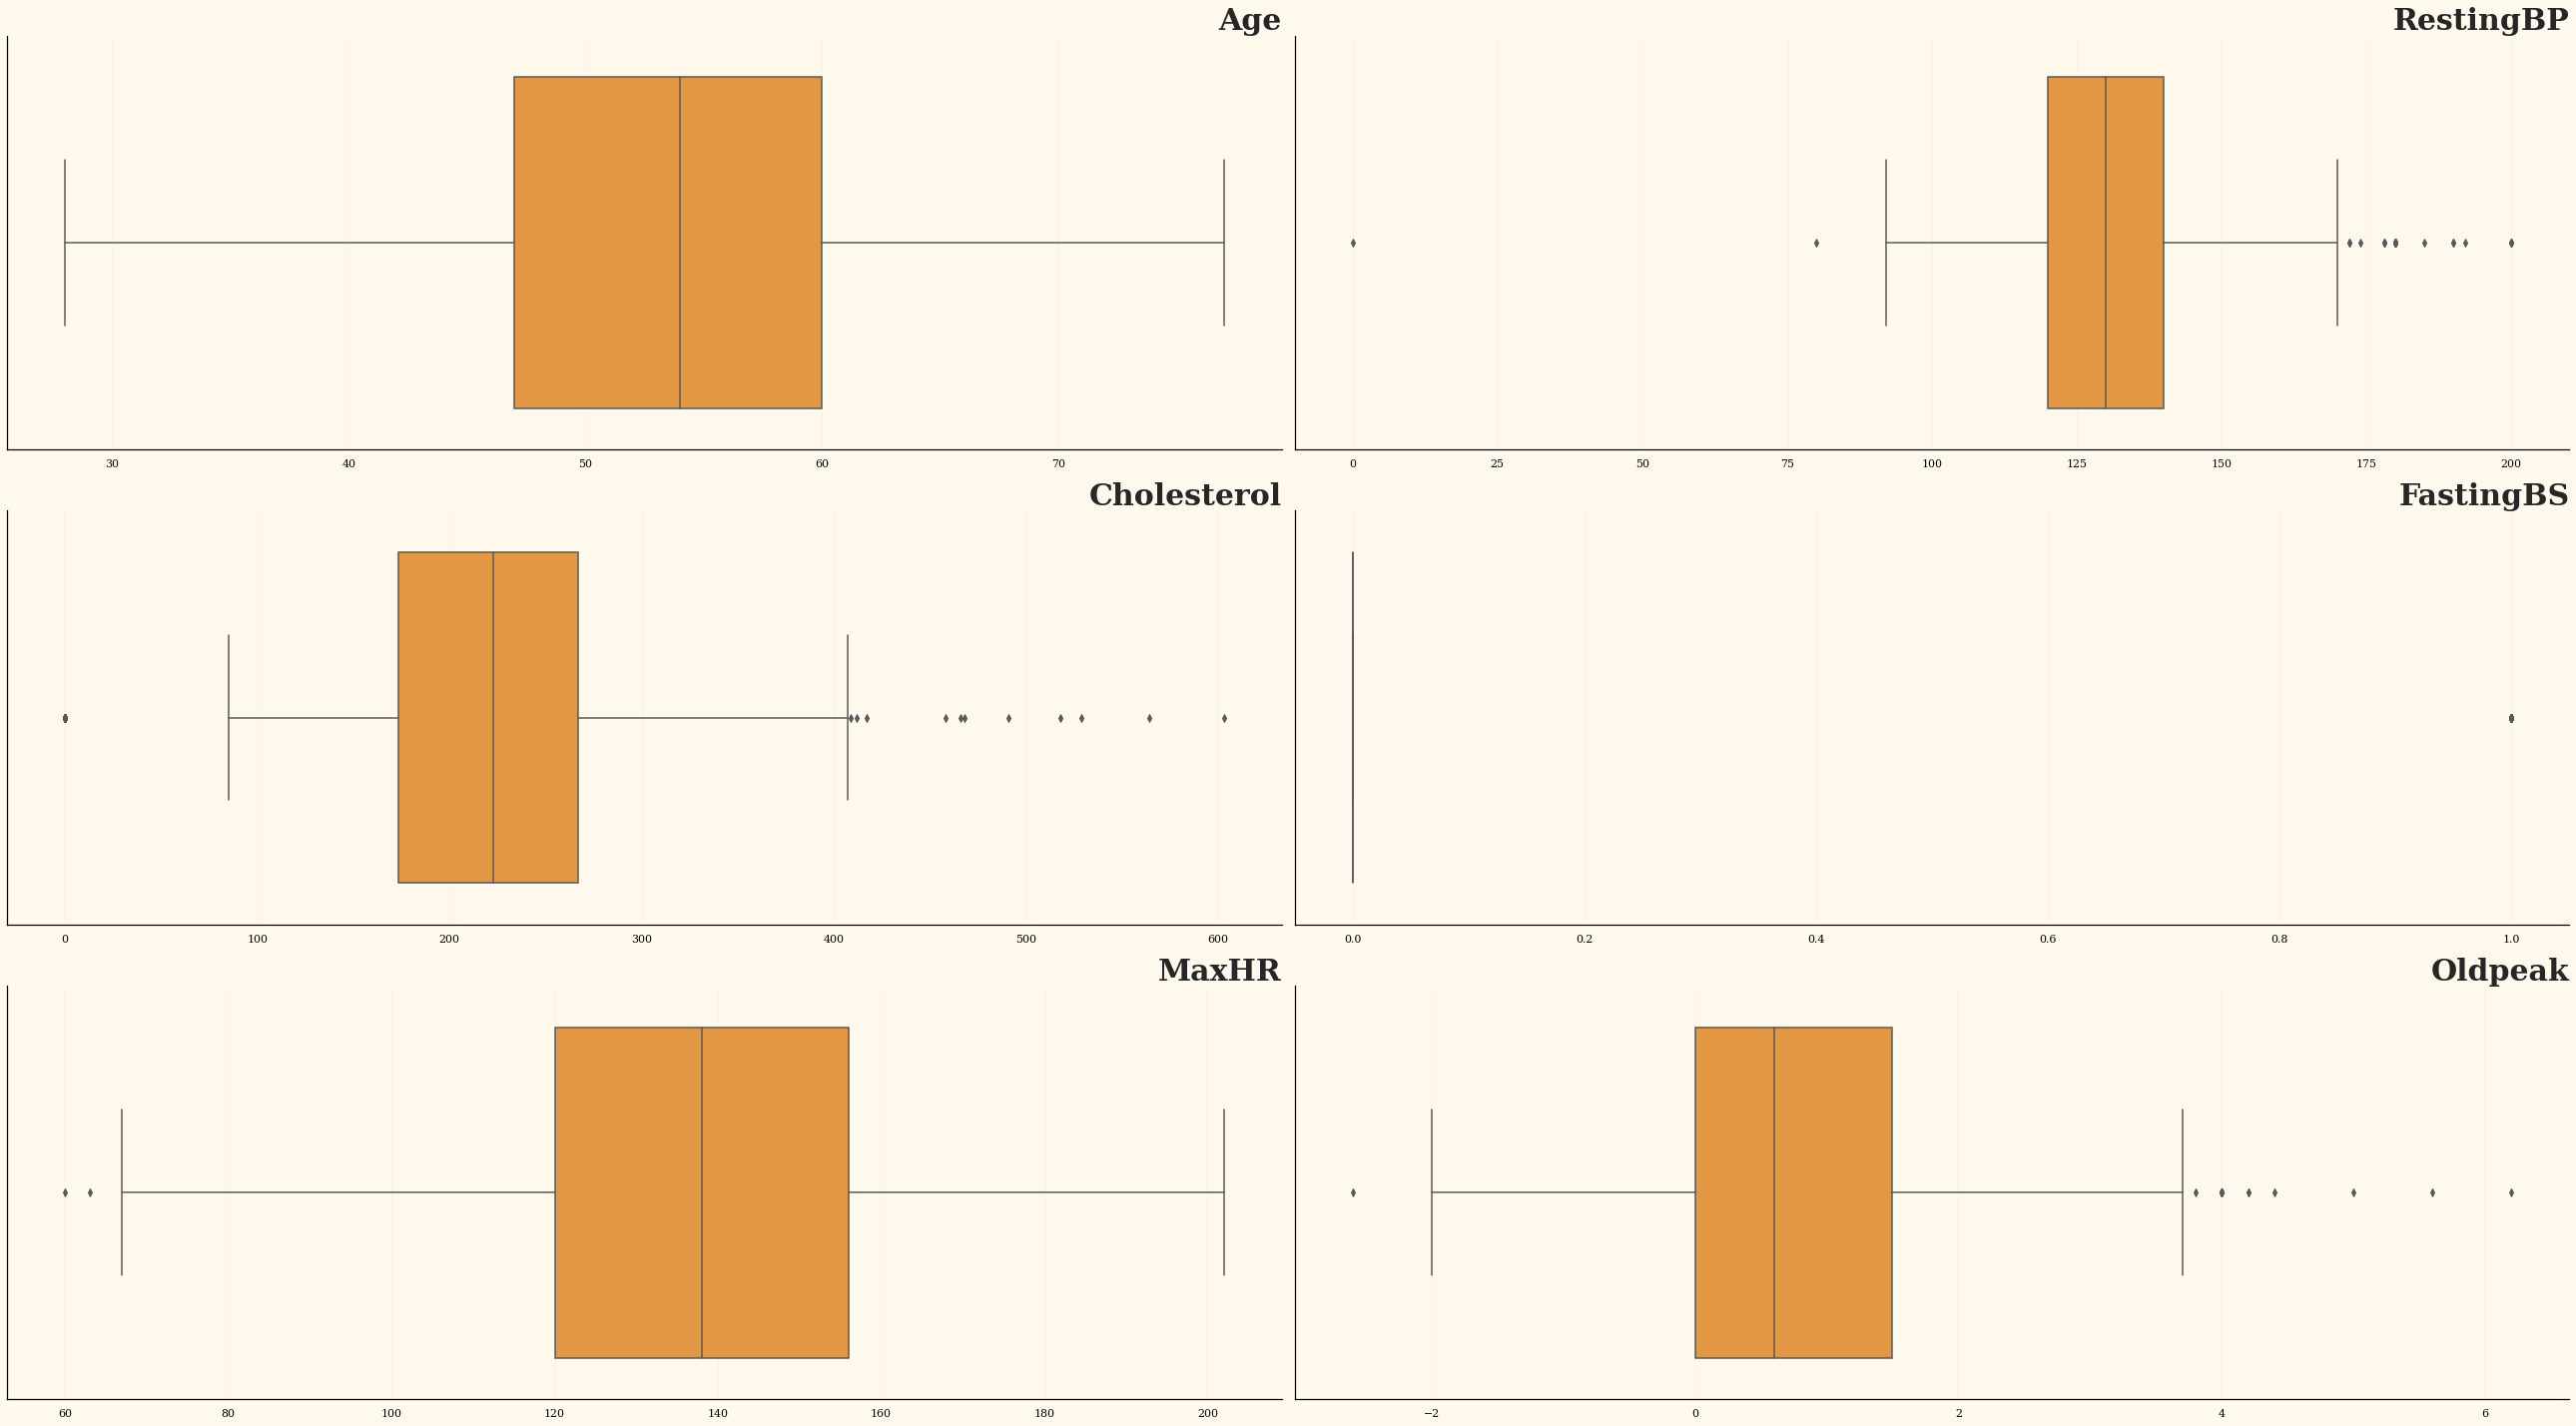

In [8]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols[:-1]):
    ax = plt.subplot(3,2, idx + 1)
    sns.boxplot(x=col,data=df,palette='YlOrBr')
                     
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=30)

plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
📌
    
* The <b>Age</b>,<b>MaxHR</b> and <b>Oldpeak</b> columns don't have any outliers 
    <hr>
* In <b>cholesterol</b> column: A total cholesterol level of 400 mg/dL is considered high. Although cholesterol has several essential functions in the body, high cholesterol puts you at greater risk for heart disease. Your total cholesterol is calculated by adding your LDL (bad) cholesterol, HDL (good) cholesterol, and 20% of triglyceride levels
* Most of the time, very low cholesterol doesn't cause a problem
* So I don't delete any rows
    <hr>
* In <b>cholesterol</b> column: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] so the 0 value dosen't matter
* So I don't delete any rows
    <hr>
* In <b>MaxHR</b> column: maximum heart rate achieved [Numeric value between 60 and 202]
* So I don't delete any rows
    <hr>
*But in <b>RestingBP</b> column the Hypotension is abnormally low blood pressure (lower than 90/60 mm Hg). If your blood pressure gets too low, it can cause dizziness, fainting or death. 
* So I will delete the row contine 0 value

In [9]:
df[df['RestingBP']==0]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
449   55   M           NAP          0            0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
449    155              N     1.50     Flat             1

In [10]:
# drop this row
df.drop(index=df[df['RestingBP']==0].index,inplace=True)

>### Exploratory Data Analysis

In [11]:
def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='target_column') -> None:
    """Draws the pie and count plots for categorical variables.
    
    Args:
        df (pd.core.frame.DataFrame): A pandas dataframe representing the data to be analyzed. 
            This could be a training set, test set, etc.
        col_list (list): A list of categorical variable column names from 'df' to be analyzed.
        title_name (str): The title of the graph. Default is 'Train'.
        
    Returns:
        None. This function produces pie and count plots of the input data and displays them using matplotlib.
    """

    # Creating subplots with 2 columns for pie and count plots for each variable in col_list
    f, ax = plt.subplots(len(col_list), 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0)

    for col in col_list:

        # Computing value counts for each category in the column
        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        # Colors for the outer and inner parts of the pie chart
        outer_colors = ['#9E3F00', '#eb5e00', '#ff781f', '#ff9752', '#ff9752']
        inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

        # Creating outer pie chart
        ax[0].pie(
            outer_sizes, colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
            textprops={'fontsize': 12, 'weight': 'bold'},
            shadow=True
        )

        # Text properties for inner pie chart
        textprops = {
            'size':13, 
            'weight': 'bold', 
            'color':'white'
        }

        # Creating inner pie chart
        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops,
            shadow=True
        )

        # Creating a white circle at the center
        center_circle = plt.Circle((0,0), .68, color='black', 
                                fc='white', linewidth=0)
        ax[0].add_artist(center_circle)

        # Barplot for the count of each category in the column
        sns.barplot(
            x=s1, y=s1.index, ax=ax[1],
            palette='YlOrBr_r', orient='horizontal'
        )

        # Customizing the bar plot
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,      
            labelbottom=False
        )

        # Adding count values at the end of each bar
        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='black', 
                        fontweight='bold', fontsize=12)

        # Adding labels and title
        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='black')
        ax[1].set_ylabel('count', fontweight="bold", color='black')

    # Setting a global title for all subplots
    f.suptitle(f'{title_name}', fontsize=20, fontweight='bold')

    # Adjusting the spacing between the plots
    plt.tight_layout()    
    plt.show()

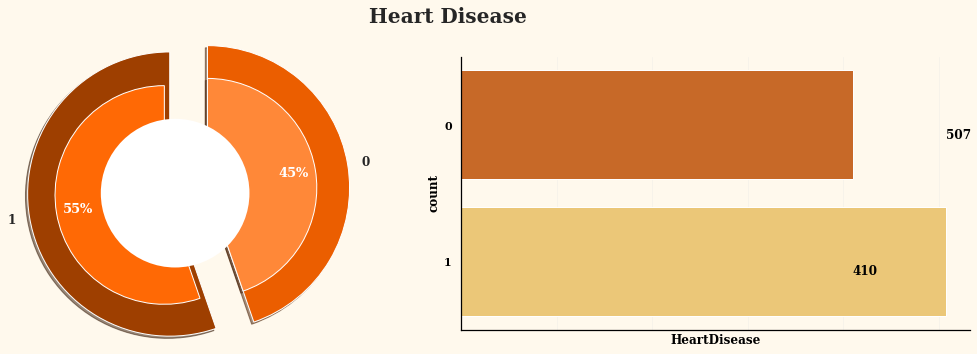

In [12]:
plot_count(df, ['HeartDisease'], 'Heart Disease')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
📌

* This is a balanced dataset !, it's good

In [13]:
fig2 = px.pie(df, names='Sex', 
             height=400, width=600, 
             hole=0.7, 
             title='Heart Disease',
             color_discrete_sequence=['orange', 'gold'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
📌

    
* The number of males is greater than femail

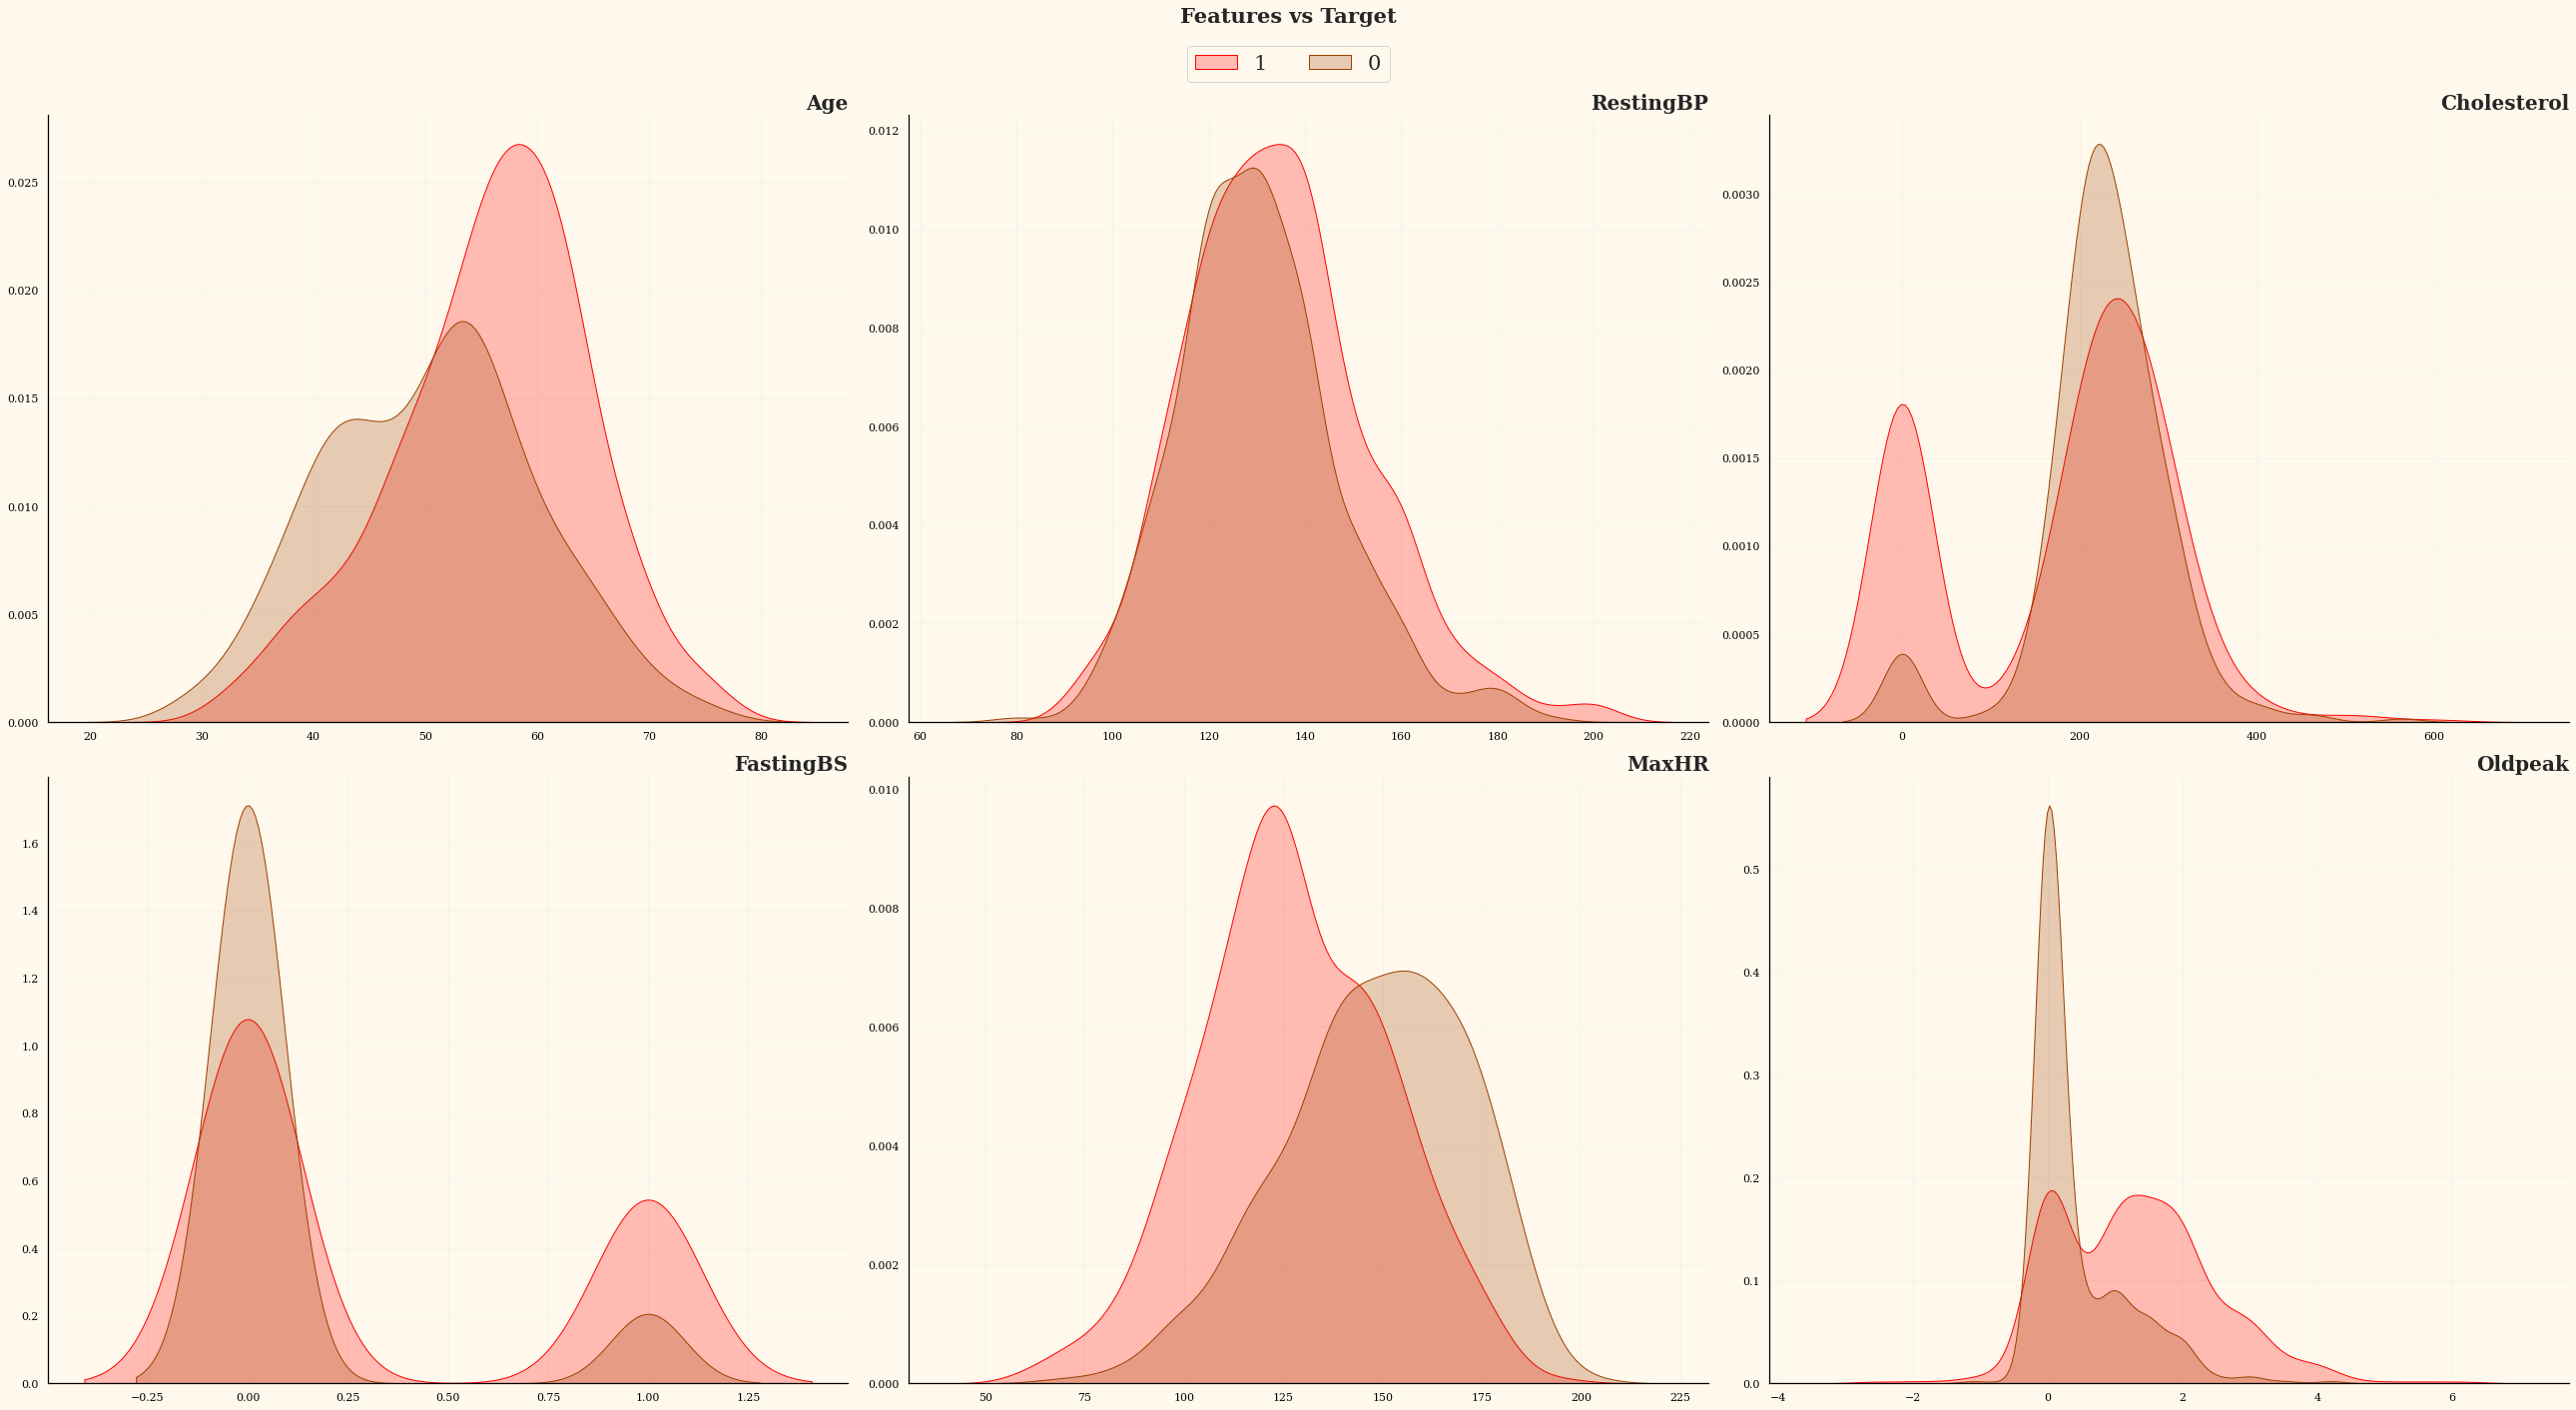

In [14]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols[:-1]):
    ax = plt.subplot(2,3, idx + 1)
    sns.kdeplot(
        data=df, hue='HeartDisease', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
📌
    
* This is noremal distribution in almost columns, but some variables need to be scaled.

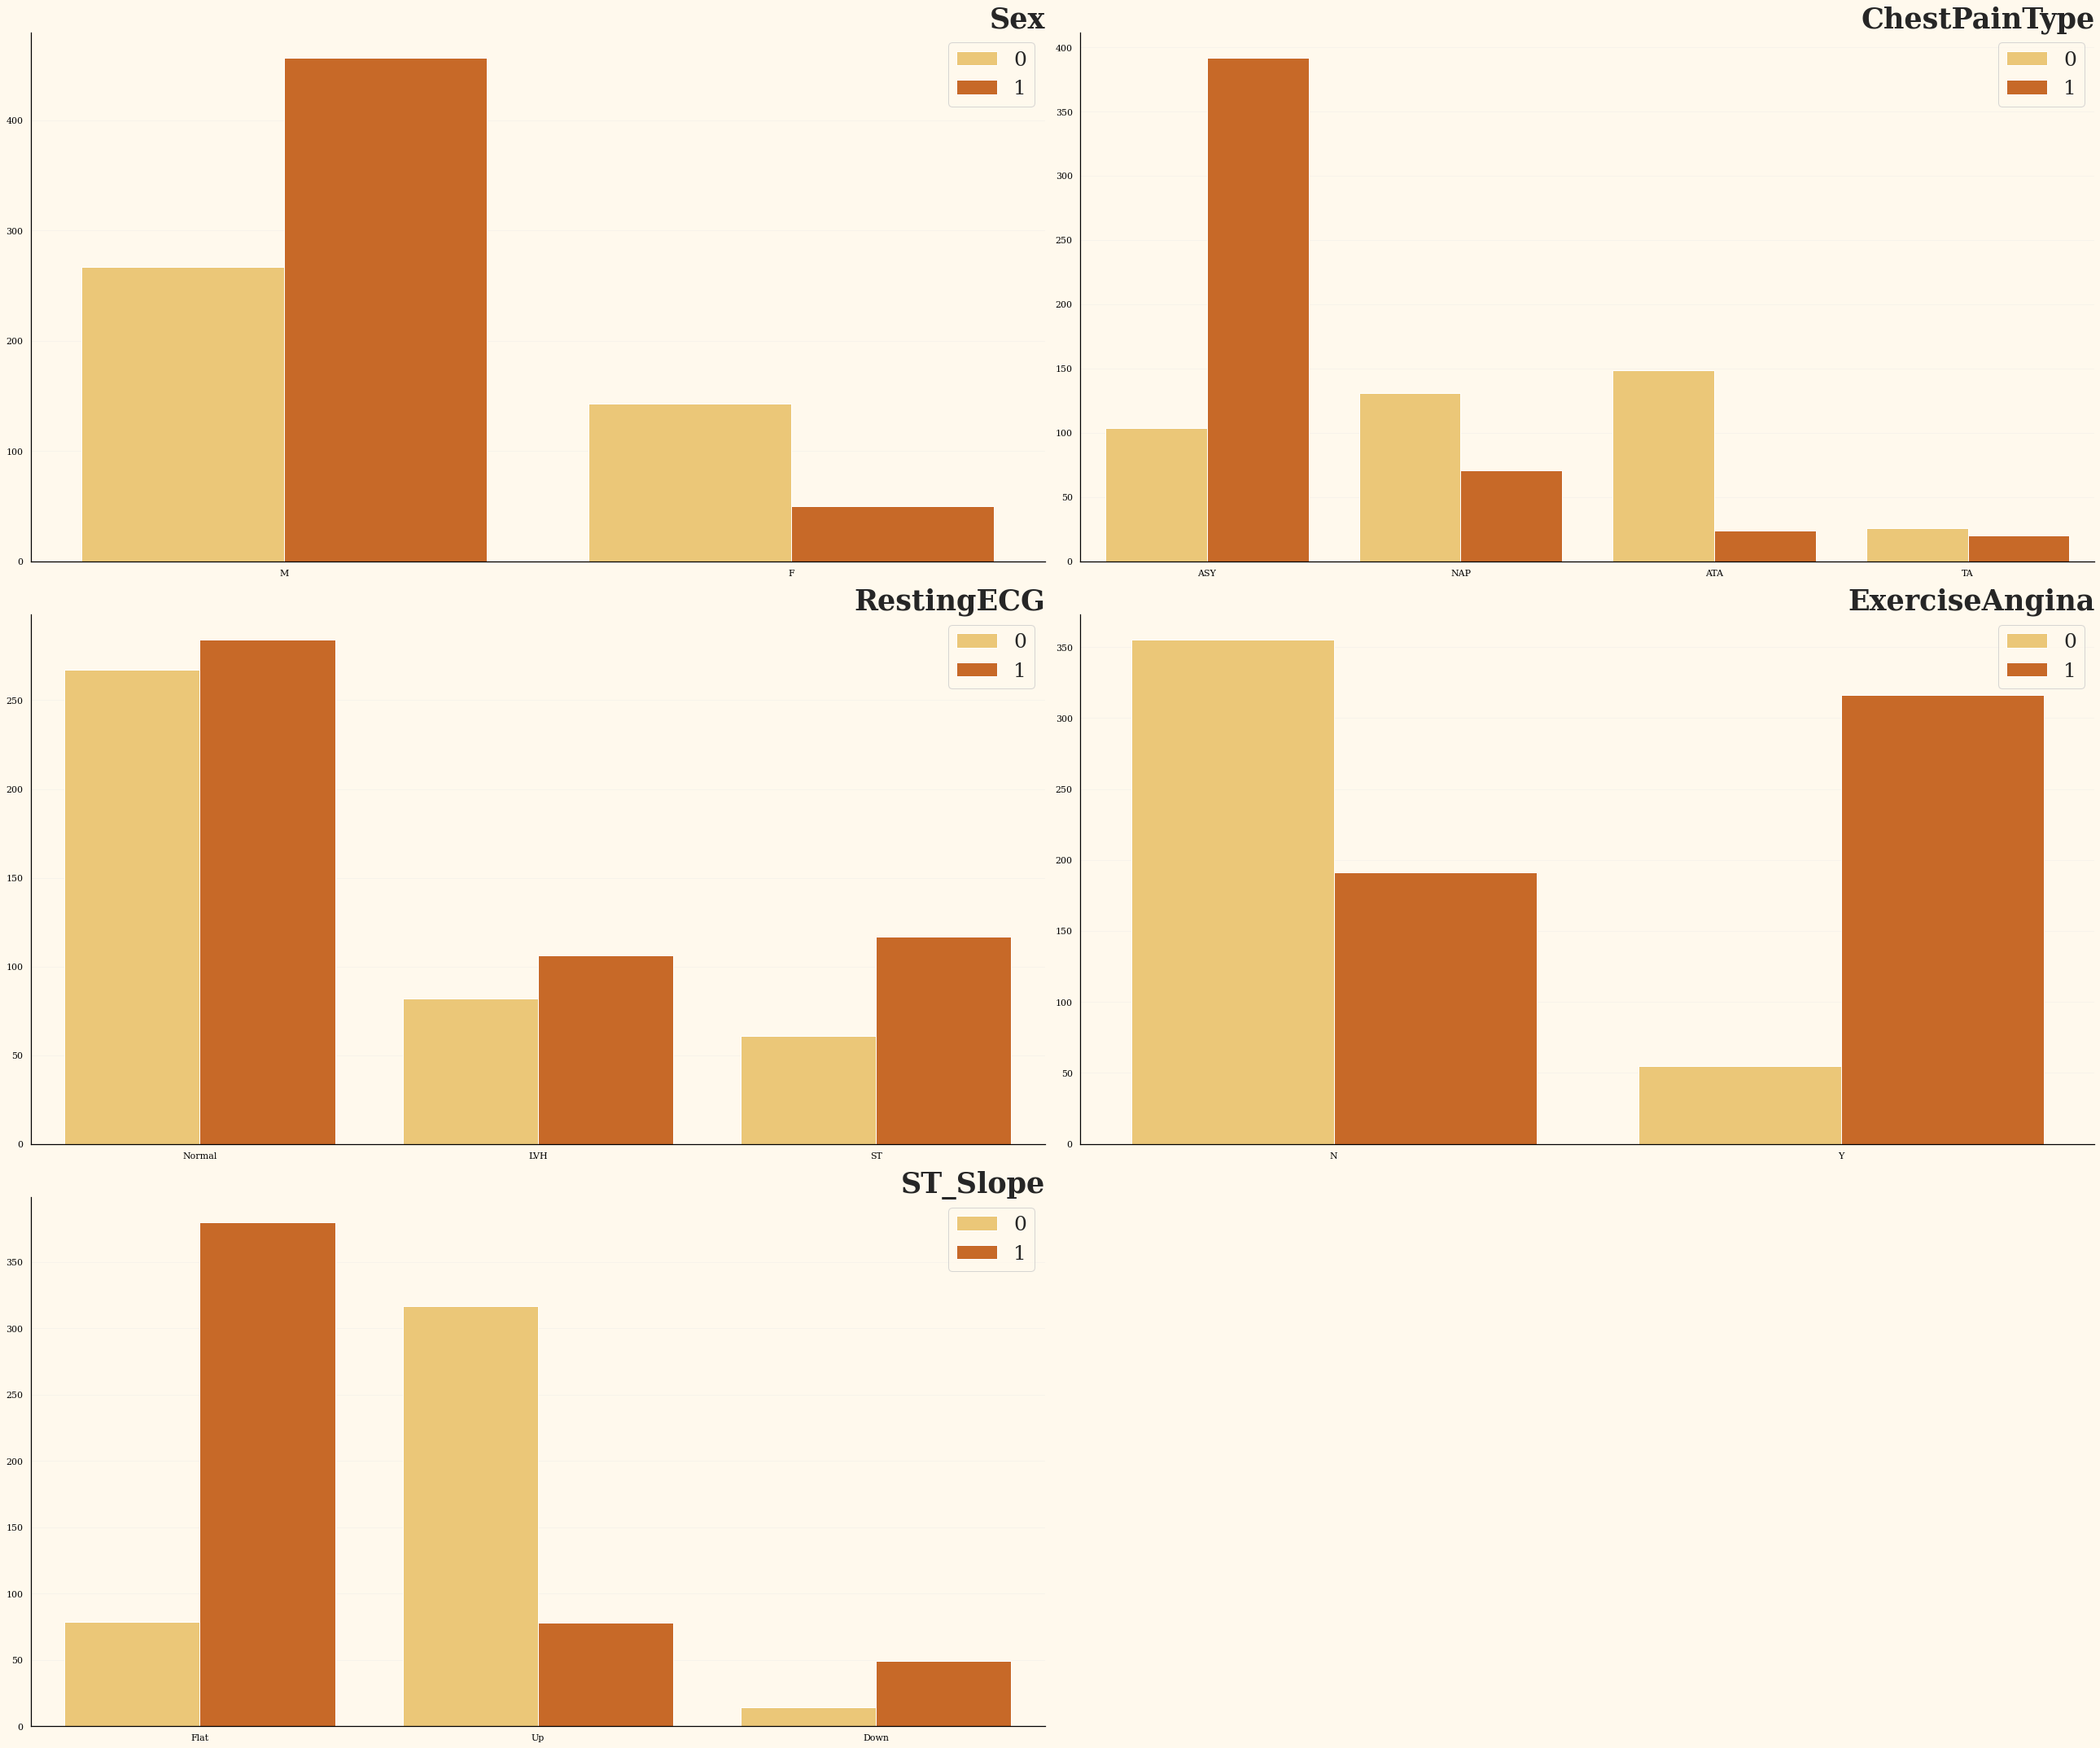

In [15]:
figsize = (6*6, 30)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(cat_cols):
    ax = plt.subplot(3,2, idx + 1)
    #sns.boxplot(x=col,data=df)
    sns.countplot(x=col,data=df,palette='YlOrBr',hue='HeartDisease', order = df[col].value_counts().index)
                 
        
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=35)
    plt.legend(fontsize=25)

plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
📌
    
* In <b>ChestPainType</b> column: show that the patients who have AST are more likely to have heart disease
* In <b>ExerclseAngina</b> column: show that the patients who have exerclse angina are more likely to have heart disease
* In <b>ST_Slope</b> column: show that the patients who have flat are more likely to have heart disease

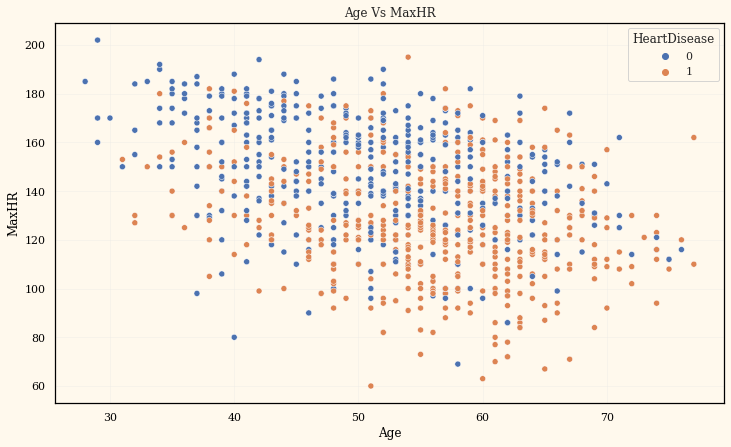

In [16]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='Age',y='MaxHR',data=df,hue='HeartDisease')
plt.title('Age Vs MaxHR' );

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

📌
    
* The scatter plot shows that when the patient is older, he will be lower in heart rate and more likely to have heart disease



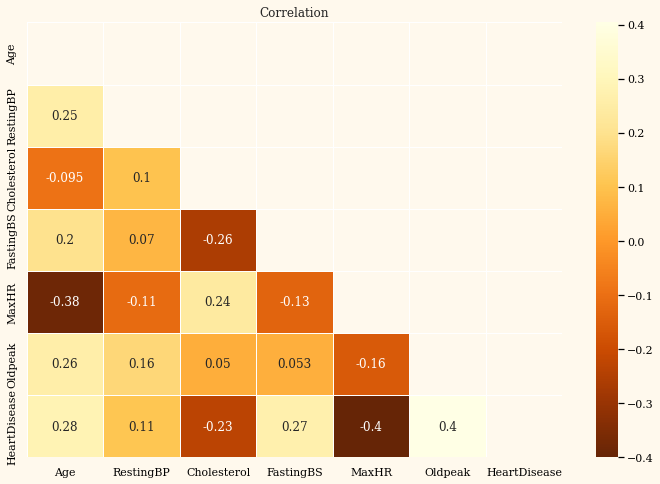

In [17]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='correlation') -> None:

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True)
    plt.title(title_name)
    plt.show()


plot_correlation_heatmap(num_col, 'Correlation')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

📌
    
* No strong correlations between varaibles.



>### Feature Engineering 

In [18]:
num_col.head().style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'})

In [19]:
cat_col.head().style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'})

In [20]:
# Convert categorical variable into dummy/indicator variable
cat_col=pd.get_dummies(cat_col)

In [21]:
# Scale numeric variables using Standard Scaler scaling
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(num_col.iloc[:,:-1]), columns=num_cols[:-1])

# Convert categorical variable into dummy/indicator variable
dummy_col_df=pd.get_dummies(cat_col)

In [22]:
scaled_numeric_df.head().style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'})

In [23]:
dummy_col_df.head().style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'})

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

📌
    
* I will delete some columns because the dummy variables include redundant information

In [24]:
# drop unnecessary columns
dummy_col_df.drop(columns=['Sex_F','ChestPainType_ASY','RestingECG_LVH','ExerciseAngina_N','ST_Slope_Down'],inplace=True)
dummy_col_df.head().style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'})

In [25]:
new_df=pd.concat([scaled_numeric_df,dummy_col_df],axis=1)
new_df['class']=df['HeartDisease']
new_df.sample(15).style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'})

In [26]:
# check for null values
new_df.isnull().sum()

Age                  0
RestingBP            0
Cholesterol          0
FastingBS            0
MaxHR                0
Oldpeak              0
Sex_M                0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_Normal    0
RestingECG_ST        0
ExerciseAngina_Y     0
ST_Slope_Flat        0
ST_Slope_Up          0
class                1
dtype: int64

In [27]:
# drop null values
new_df.dropna(inplace=True)

In [28]:
x=new_df.iloc[:,:-1]
y=new_df.iloc[:,-1]

x_shape=colored(x.shape, "red")
y_shape=colored(y.shape, "red")

print('The dimensions of x is : ',x_shape)
print('The dimensions of y is : ',y_shape)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=1,shuffle=True)
x_train_shape=colored(x_train.shape, "red")
x_test_shape=colored(x_test.shape, "red")
y_train_shape=colored(y_train.shape, "red")
y_test_shape=colored(y_test.shape, "red")

print("x train dimensions :",x_train_shape)
print("x test dimensions: ",x_test_shape)
print("y train dimensions :",y_train_shape)
print("y test dimensions :",y_test_shape)

The dimensions of x is :  (917, 15)
The dimensions of y is :  (917,)
x train dimensions : (733, 15)
x test dimensions:  (184, 15)
y train dimensions : (733,)
y test dimensions : (184,)


> ### Data Modeling

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

📌

### Model Selection Workflow Using Cross-Validation !
    
    
#### What is model selection?
* Model selection is the process of choosing the best ml model for a given task. It is done by comparing various model candidates on chosen evaluation metrics calculated on a designed evaluation schema. Choosing the correct evaluation schema, whether a simple train test split or a complex cross-validation strategy, is the crucial first step of building any machine learning solution.
    
#### What is Cross-Validation?
* Cross-validation is a fundamental technique used in machine learning to evaluate the performance of a model on an independent dataset. Its objective is to estimate how well a trained model will generalize to unseen or new data.

* The process involves taking the available dataset and dividing it into multiple subsets or folds. Typically, a common approach is k-fold cross-validation, where the data is partitioned into k equal-sized folds. Then, the model is trained k times, using k-1 folds for training and the remaining fold for validation. This allows for evaluating the model's performance on each fold.
    
#### This is the workflow of how the data is being used:

1. training dataset is used to train a few candidate models
2. validation dataset is used to evaluate the candidate models
3. one of the candidates is chosen
4. the chosen model is trained with a new training dataset
5. the trained model is evaluated with the test dataset 
    
    
* In steps 1 and 2, we do not want to evaluate the candidate models once. Instead, we prefer to evaluate each model multiple times with different dataset and take the average score for our decision at step 3. We can use the trick of k-fold to resample the same dataset multiple times and pretend they are different. As we are evaluating the model, or hyperparameter, the model has to be trained from scratch, each time, without reusing the training result from previous attempts. We call this process cross validation.

* From the result of cross validation, we can conclude whether one model is better than another. Since the cross validation is done on a smaller dataset, we may want to retrain the model again, once we have a decision on the model. The reason is the same as that for why we need to use k-fold in cross-validation. We believe combining the training and validation dataset can produce a better model. This is what would occur in step 4.

* The dataset for evaluation in step 5, and the one we used in cross validation, are different because we do not want data leakage. If they were the same, we would see the same score as we have already seen from the cross validation. Or even worse, the test score was guaranteed to be good because it was part of the data we used to train the chosen model and we have adapted the model for that test dataset.
    
<hr>
    

* Let's now go to modeling, but first what models will I use? the answer is <b> Ensemple Learning</b> models 
    
#### What is Ensemple Learning?

* Ensemble learning is a machine learning technique that combines the predictions of multiple individual models to improve the overall prediction accuracy. It works by training multiple models on the same dataset and aggregating their predictions to make a final prediction.

* Now, let's discuss the difference between bagging and boosting in brief:

* Bagging (Bootstrap Aggregating): Bagging is a technique where multiple models are trained on different subsets of the training data. Each model is trained independently, and their predictions are combined, typically by averaging or voting, to make the final prediction. Bagging helps reduce the variance in predictions and improve the overall model stability. One popular example of bagging is the Random Forest algorithm, which combines the predictions of multiple decision trees to make predictions.

* Boosting: Boosting, on the other hand, is a technique where multiple models are trained sequentially, where each subsequent model focuses more on the samples that were misclassified by previous models. Boosting aims to correct the weaknesses of the individual models and improve the overall prediction accuracy. In boosting, each model is trained to learn from the mistakes made by the previous models, therefore, giving more importance to the difficult or misclassified samples. Popular boosting algorithms include Gradient Boosting Machines (GBMs) and AdaBoost.
    
#### In summary:

<br><center><img src='https://i.postimg.cc/5t93Rr1j/parallel.gif' height=500px width=1000px></center><br>
    
#### The models I will use: 

* RandomForestClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
* XGBClassifier 

In [29]:
%%time
models=[RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(),XGBClassifier()]
cv = KFold(n_splits=10, shuffle=True, random_state=42)

Avg_TrainR2Value=[]
Avg_TestR2Value=[]
Avg_TrainMSEValue=[]
Avg_TestMSEValue=[]

for model in models:
    CrossValidate= cross_validate(model, x_train, y_train, cv=cv, return_train_score = True
                                                                 ,scoring=('r2','neg_mean_squared_error'))
    Avg_TrainR2Value.append(CrossValidate['train_r2'].mean())
    Avg_TestR2Value.append(CrossValidate['test_r2'].mean())
    Avg_TrainMSEValue.append(CrossValidate['train_neg_mean_squared_error'].mean())
    Avg_TestMSEValue.append(CrossValidate['test_neg_mean_squared_error'].mean())

models_name= ["RandomForestClassifier", "AdaBoostClassifier", "GradientBoostingClassifier","XGBClassifier"]
summary_models_df=pd.DataFrame({'Model':models_name , 'Train R2 Value':Avg_TrainR2Value, 'Test R2 Value':Avg_TestR2Value,
                             'train MSE Value':Avg_TrainMSEValue,'Test MSE Value':Avg_TestMSEValue})
summary_models_df.style.set_properties(**{'background-color': '#FFF9ED',
                           'color': 'black',
                           'border-color': 'white'})

Wall time: 6.93 s


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

📌
    
* there are overfitting in RandomForestClassifier, GradientBoostingClassifier, XGBClassifier but there are underfitting in AdaBoostClassifier 
* I will use GradientBoostingClassifier	 algorithm with GridSearchCV to tunning hyperparameter

In [30]:
%%time
model=GradientBoostingClassifier()
parameters = {#'nthread':[3,4], #when use hyperthread, xgboost may become slower
               "criterion": ["friedman_mse",  "mae"],
              "loss":["deviance","exponential"],
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.1,1,0.5], #so called `eta` value
              'max_depth': [2,3,4,5],
              'min_samples_leaf': [2,3,4,5],
              'subsample': [0.4,0.6,0.7,0.8],
              'n_estimators': [50,55,60,100],#number of trees, change it to 1000 for better results

              }

grid_search = GridSearchCV(model, parameters, n_jobs=5,verbose=2, cv=cv)
grid_result = grid_search.fit(x_train, y_train);

Fitting 10 folds for each of 8192 candidates, totalling 81920 fits
Wall time: 25min 3s


In [53]:

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.885487 using {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 60, 'subsample': 0.8}


In [63]:
best_model=GradientBoostingClassifier( criterion= 'friedman_mse', learning_rate= 0.1, loss= 'exponential',
                                      max_depth= 2, max_features= 'log2', min_samples_leaf= 4,
                                      n_estimators= 60, subsample= 0.8)
best_model.fit(x_train,y_train)
print("train score",np.round(best_model.score(x_train,y_train),3)," % \n")
print("test score",np.round(best_model.score(x_test,y_test),3)," % \n");

train score 0.892  % 

test score 0.891  % 



<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
📌
    
* GridSearchCV helped me to tun the parameters and obtain the best parameters 
* GridSearchCV helped me to eliminate overfitting

>### Evaluation and Visualization

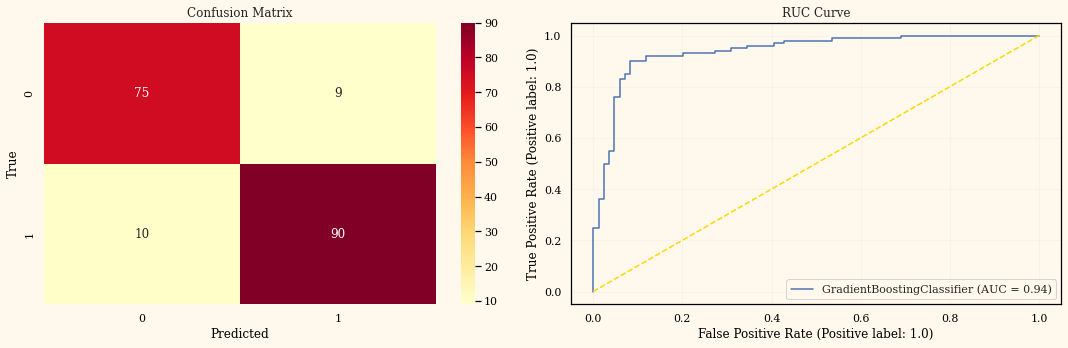

In [33]:
# Subplot 1: Confusion Matrix
cm = confusion_matrix(y_test, best_model.predict(x_test))
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='YlOrRd')
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Subplot 2: AUC
y_proba= best_model.predict_proba(x_test)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay.from_estimator(best_model, x_test, y_test,ax=ax[1])
sns.lineplot(x = [0, 1], y = [0, 1], color = 'gold', linestyle="dashed",ax=ax[1])
ax[1].set_title('RUC Curve')

plt.tight_layout()
plt.show();

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

📌
    
* Classification results semes not bad.

* RUC curve is good and the AUC 0.94 very good

In [34]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],palette='YlOrBr_r')
    #Add chart labels
    plt.title(model_type + 'Featue Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

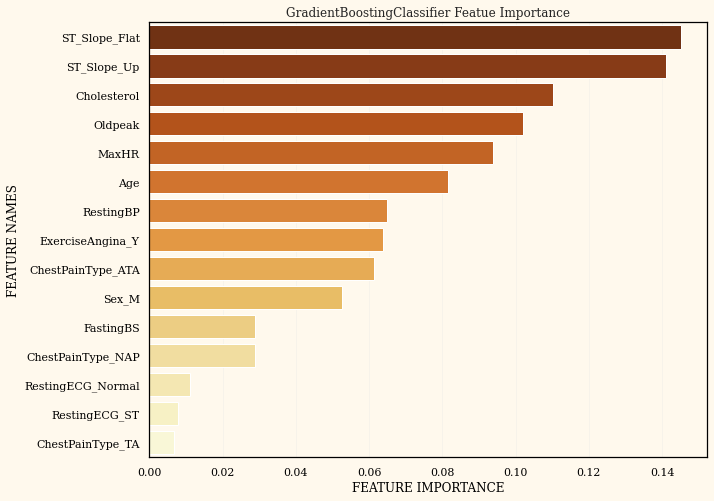

In [35]:
plot_feature_importance(best_model.feature_importances_,new_df.columns[:-1],'GradientBoostingClassifier ')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>Reference: </font></h3>

* <a href= 'https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html'>Random Forest Feature Importance Plot</a>
    
* <a href= 'https://neptune.ai/blog/ml-model-evaluation-and-selection'>The Ultimate Guide to Evaluation and Selection of Models in Machine Learning</a>
    
* <a href= 'https://www.kaggle.com/code/arezalo/ml-studytime-2-cross-validation'>📚The ML StudyTime 2: Cross Validation</a>
* <a href= 'https://www.kaggle.com/code/arezalo/ml-studytime-5-ensemble-learning'>📚The ML StudyTime 5: Ensemble Learning</a>
* <a href= 'https://www.kaggle.com/code/kimtaehun/spaceship-complete-template-for-classification'>🛸Spaceship - Complete template for classification</a>
    

 <center><img src="https://www.icegif.com/wp-content/uploads/2021/12/icegif-1127.gif" width="800"></center><br></br>
 <h3 align="left"><font color='#DEB887'>
thank you for reading to the end, your advice and comments are important to me. Don't forget to upvote this notebook if you like it! ❤️
    </font></h3> 